In [ ]:
# class EventBasedBacktester:
#     def __init__(self, symbol, start, end, interval, capital, transcation_cost, verbose = True, leverage = False):
#     # def prepare_data(self):
#     # def plot_close_graph(self):
#     # def return_date_price(self, bar):
#     # def realized_balance(self, bar):
#     # def unrealized_balance(self, bar):
#     # def total_balance(self, bar):
#     # def buy_order(self, quantity = None, dollar = None):
#     # def sell_order(self, quantity = None, dollar = None):
#     # def last_trade(self, bar):

In [58]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime

class StrategyBacktester:
  """
  Event-Based Backtester.
  """
  def __init__(self, symbol, start, end, interval, capital, transcation_cost, verbose = True):
    self.symbol = symbol
    self.start = start
    self.end = end
    self.interval = interval
    self.initial_capital = capital # this is the initial capital you want to trade with
    self.capital = capital # this capital will change depending on trades
    self.transaction_cost = transcation_cost # the transaction cost for trading
    self.quantity = 0 # quantities to buy/sell
    self.position = 0 # the trades in progress, long or short
    self.trades = 0 # Number of trades
    self.verbose = verbose # if you want to see detailed output (logs)
    self.stored_data = pd.DataFrame(columns = ['trade', 'date', 'position', 'price', 'symbol', 'quantity', 'capital']) # to store trade details
    self.data = None
    self.prepare_data() # prepares the data

  def prepare_data(self):
    # since we are building a common class for all types of strategy, we will not calcualte the moving averages now.
    # we will calculate the returns though.
    # Since most strategies utilise close prices we are only factoring close price. However, you can alter acoordingly.

    stock_data = yf.Ticker(self.symbol)
    hist_stock = stock_data.history(start = self.start, end = self.end, interval = self.interval)

    bt_data = pd.DataFrame()
    bt_data["Close_Price"] = hist_stock["Close"]
    bt_data["Return"] = np.log(bt_data["Close_Price"] / bt_data["Close_Price"].shift(1))
    bt_data = bt_data.dropna()
    self.data = bt_data

  def close_graph(self):
    plt.figure(figsize=(15, 5)) 
    plt.plot(self.data["Close_Price"] ,color='black', label='Price', linestyle='dashed')
    plt.xlabel("Days")
    plt.ylabel("Price")
    plt.title("Close Prices of {}".format(self.symbol))
    plt.legend()
    plt.grid()
    plt.show()

  def return_date_price(self, bar):

    # A bar is a unit of data at a given time, depends on the interval you choose, it provides you OHLCV and time info
    # Since we have modeled close prices, we will get the price and date

    date = self.data.index[bar].date()
    price = self.data.Close_Price.iloc[bar]
    return date, price

  def realised_balance(self, bar):

    #Returns you the realised capital in your account at a given time period / bar

    date, price = self.return_date_price(bar)
    print("Date :{} | Realised Balance: {:0.1f}".format(date,self.capital))

  def unrealised_balance(self, bar):

    #Returns you the unrealised capital (trades in progress) in your account at a given time period / bar

    date, price = self.return_date_price(bar)
    ub = self.quantity *price
    print("Date :{} | Unrealised Balance: {:0.1f}".format(date,ub))

  def total_balance(self, bar):

    #Unrealised plus realised

    date, price = self.return_date_price(bar)
    tb = self.quantity *price + self.capital

    print("Date :{} | Total Balance: {:0.1f}".format(date,tb))

  def store_results(self, trade, date, position, price, symbol, quantity, capital):
    trade_detail = pd.DataFrame({'trade':pd.Series(trade), 'date':pd.Series(date), 'position':pd.Series(position), 'price':pd.Series(price), 'symbol':pd.Series(symbol), 'quantity':pd.Series(quantity), 'capital':pd.Series(capital) })
    self.stored_data = pd.concat([self.stored_data, trade_detail])


  def performance(self):

    # Creating a temporary variable B to do all calculations
    # I could have also copied stored data, but I like single letter variables ( not recommended)

    B = self.stored_data
    B.index = range(B.shape[0]) # shape[0] to get the length of rows

    #Preparing metrics to calculate performance

    B['exit_date'] = B['date'].shift(-1) # The data was stored as a series of Buy / Sell or Sell / Buy in order
    B['exit_price'] = B['price'].shift(-1)
    B['capital_after_settlement'] = B['capital'].shift(-1)

    # Since we are are utilising capital, we will calculate returns for SR based on daily capital/equity changes
    #Remember, you can change the returns on investment based on the amount/capital you trade. So, its not like all returns are realised

    B['capital_regular_returns'] = (B['capital_after_settlement']/B['capital'] - 1)
    B['capital_log_returns'] = np.log(B['capital_after_settlement']/B['capital'])
    B["capital_returns_log_cum_sum"] = B["capital_log_returns"].cumsum()
    B.drop(B.index[B['capital_log_returns'] == 0.0], inplace=True) #Dropping the last column, as I already got the values through shift(1)
    B = B.dropna()

    #arranging the columns for better readeability
    cols =['trade','symbol','position','quantity','date', 'exit_date', 'price','exit_price','capital','capital_after_settlement', 'capital_regular_returns', 'capital_log_returns', 'capital_returns_log_cum_sum']
    B = B[cols]
    B.rename(columns = {'date':'entry_date', 'price':'entry_price'}, inplace = True)

    #storing the results in Final_result data
    Final_result_data = B
    Final_result_data

    #Plot the equity curve
    plt.plot(Final_result_data['exit_date'],Final_result_data['capital_after_settlement'])

    # Annual gross expected returns
    daily_log_mean_ret = Final_result_data['capital_log_returns'].mean()
    annual_log_ret = 252 * daily_log_mean_ret
    annual_regular_return = (np.exp(annual_log_ret) -1)*100
    print("The annual regular returns are {:0.2f} %".format(annual_regular_return))

    # Annual std deviation
    daily_regular_std = (np.exp(Final_result_data['capital_log_returns'])-1).std()
    annual_regular_std =  daily_regular_std * (252 **0.5) *100
    print("The annual regular std deviation  is {:0.2f} %".format(annual_regular_std))

    #Annual Sharpe Ratio
    SR = annual_regular_return / annual_regular_std
    print("The annual Sharpe Ratio is {:0.2f}".format(SR))

    #The strategy returns on investment in percent
    Total_Log_ret = Final_result_data['capital_log_returns'].sum()
    Total_Log_ret
    Regular_ROI = (np.exp(Total_Log_ret) - 1) *100
    print("The returns on investment from {} to {} by this strategy is {:0.1f} %".format(self.start, self.end, Regular_ROI))

    #print("The histogram of returns")
    #Final_result_data['capital_log_returns'].hist(bins= 40)


  def buy_order(self,bar,quantity=None, dollar =None ):
    date, price = self.return_date_price(bar)
    if quantity == None:
      quantity = int(dollar/price)
    self.capital = self.capital - ((quantity * price)*(1 + self.transaction_cost)) # capital will be lost in buying
    self.quantity = self.quantity + quantity
    self.trades = self.trades + 1
    self.position = 1 #(To be stored in results. Will need for calculations)
    self.store_results(self.trades, date, self.position, price, self.symbol, quantity, self.quantity*price + self.capital)


    if self.verbose:
      print("Bought {} shares of {} at {:0.1f} per share worth {:0.1f} $".format(quantity,self.symbol, price, quantity * price))
      self.realised_balance(bar)
      self.unrealised_balance(bar)
      self.total_balance(bar)


  def sell_order(self,bar,quantity=None, dollar=None ):
    date, price = self.return_date_price(bar)
    if quantity == None:
      quantity = int(dollar/price)
    self.capital = self.capital + ((quantity * price)*(1 - self.transaction_cost)) # capital will be added after selling
    self.quantity = self.quantity - quantity
    self.trades = self.trades + 1
    self.position = -1
    self.store_results(self.trades, date, self.position, price, self.symbol, quantity, self.quantity*price + self.capital)


    if self.verbose:
      print("Sold {} shares of {} at {:0.1f} per share worth {:0.1f} $".format(quantity,self.symbol, price, quantity * price))
      self.realised_balance(bar)
      self.unrealised_balance(bar)
      self.total_balance(bar)

  def last_trade(self, bar):
    date, price = self.return_date_price(bar)
    last_quantity = self.quantity
    self.capital = self.capital + last_quantity * price
    self.quantity = 0 # as no more quantity now. all will be settled
    self.trades = self.trades +1
    if self.position == -1: # if closing out a short position
      last_quantity = - last_quantity # to keep a positve nymber in records
      self.position = 1 # to record we are buying to close out
    else:
      last_quantity =  last_quantity # to keep a positve nymber in records
      self.position = -1 # to record we are selling to close out
    #self.position = 0

    self.store_results(self.trades, date, self.position, price, self.symbol, last_quantity, self.quantity*price + self.capital)
    print("=" *50)
    print("--------------Final Balance-----------")
    self.total_balance(bar)
    print("=" *50)

    if self.verbose:
      print("Closed open trades for {} shares of {} at {:0.1f} per share worth {:0.1f} $".format(last_quantity,self.symbol, price, last_quantity * price))
      print("--------------Final Balance-----------")
      self.total_balance(bar)
      returns = (self.capital - self.initial_capital) /self.initial_capital *100
      print("------------------------------")
      print("The total capital at end of strategy: {:0.1f}".format(self.capital))
      print( "The strategy returns on investment are {:0.1f} %".format(returns))
      print( "Total trades by startegy are {:0.1f}".format(self.trades))

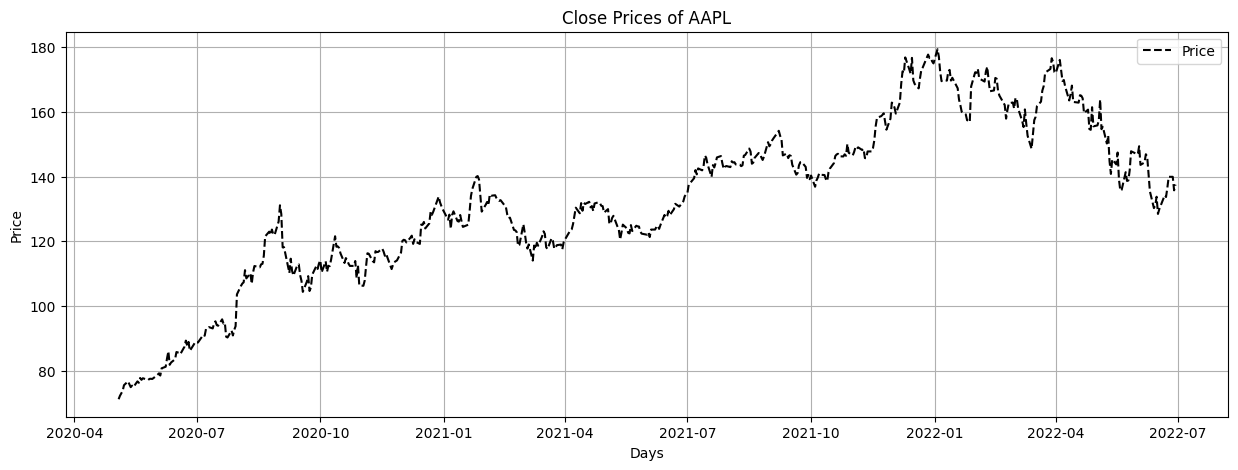

/var/folders/76/sv22wlqx51l_7wpcjlt9ds2c0000gn/T/ipykernel_2933/4015981007.py:86: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.stored_data = pd.concat([self.stored_data, trade_detail])


End of last bar
--------------Final Balance-----------
Date :2022-06-29 | Total Balance: 10846.9
   trade        date position       price symbol quantity       capital
0      1  2021-02-18        1  127.166870   AAPL       39  10000.000000
0      0  2021-02-19        1  127.323738   AAPL       39  10006.117851
0      0  2021-02-22        1  123.529602   AAPL       39   9858.146545
0      0  2021-02-23        1  123.392349   AAPL       39   9852.793686
0      0  2021-02-24        1  122.892334   AAPL       39   9833.293091
..   ...         ...      ...         ...    ...      ...           ...
0      0  2022-06-24       -1  139.913284   AAPL       34  10765.321884
0      0  2022-06-27       -1  139.913284   AAPL       34  10765.321884
0      0  2022-06-28       -1  135.745331   AAPL       34  10907.032303
0      0  2022-06-29       -1  137.513229   AAPL       34  10846.923752
0      4  2022-06-29        1  137.513229   AAPL       34  10846.923752

[346 rows x 7 columns]
The annual regu

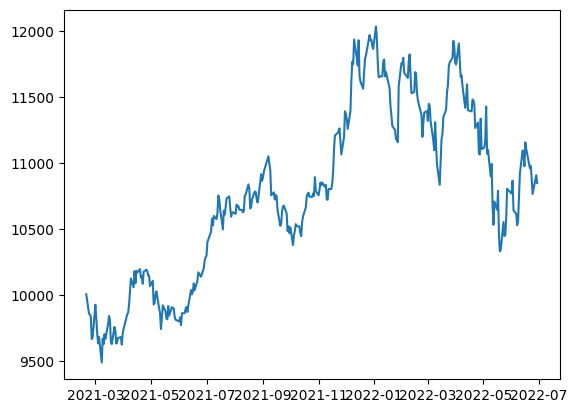

In [126]:
from ta.trend import SMAIndicator

class MA_Strategy(StrategyBacktester):
  def __init__(self, symbol, start, end, interval, capital, transcation_cost, strategy_name, verbose = True):
    super().__init__(symbol, start, end, interval, capital, transcation_cost, verbose)
    self.strategy_name = strategy_name
  def go_long(self, bar, quantity = None, dollar = None): # either previously in position or fresh position
    if self.position == -1:
      self.position = 0
      self.buy_order(bar, quantity = -self.quantity) #to clear previous short position and therefore negative quantity.(already in position, thats why negative)
    if quantity:
      self.buy_order (bar, quantity = quantity) # to create new fresh order
    elif dollar:
      if dollar == 'all':
        dollar = self.capital
      self.buy_order(bar, dollar = dollar)


  def go_short(self, bar, quantity = None, dollar = None):
    if self.position == 1:
      self.position = 0
      self.sell_order(bar, quantity = self.quantity) #to clear previous long vposition
    if quantity:
      self.sell_order (bar, quantity = quantity) # to create new fresh order
    elif dollar:
      if dollar == 'all':
        dollar = self.capital
      self.sell_order(bar, dollar = dollar)

  def run_strategy(self, STMA_window, LTMA_window): # add the parameters according to the strategy
    self.position = 0
    self.trades = 0
    self.capital = self.initial_capital

    indicator_1 = SMAIndicator(close = self.data ["Close_Price"], window = STMA_window, fillna= False)
    STMA = indicator_1.sma_indicator()

    indicator_2 = SMAIndicator(close = self.data ["Close_Price"], window = LTMA_window, fillna= False)
    LTMA = indicator_2.sma_indicator()

    self.data["STMA"] = STMA
    self.data["LTMA"] = LTMA

    for bar in range(LTMA_window, len(self.data)): # from the available data bar to the last data bar
      date, price = self.return_date_price(bar)

      if self.position in [0,-1]: # checking no position or short position
        if self.data["STMA"].iloc[bar]>self.data["LTMA"].iloc[bar]:
          self.go_long(bar, dollar=5000) # go with all money # Make sure to enter less than initila capital
          #print("--------")
          continue # as I am storing data for SR calculations. Dont wnat duplication. Continue to make sure 0 is added only on no conditions day

      if self.position in [0,1]: # checking no position or long position
        if self.data["STMA"].iloc[bar]<self.data["LTMA"].iloc[bar]:
          self.go_short(bar, dollar =5000) # go with all money
          #print("--------")
          continue

      #-----Storing all the values for calculating Sharpe-----
      store_quantity = abs(self.quantity) # so that I want just the positive numbers in my performance table. I will calculate +/- based on self.position sign
      self.store_results(0, date, self.position, price, self.symbol, store_quantity, self.quantity*price + self.capital)

    print("=" *50)
    print("End of last bar")
    print("=" *50)
    self.last_trade(bar)  # amke sure the crossover happens, give more time
    #print(self.stored_data.to_string())
    print(self.stored_data)


A = MA_Strategy("AAPL", "2020-05-01", "2022-06-30","1d",10000, 0.0, "AAPL MAStrategy 50/200", False)
A.close_graph()
A.run_strategy(50,200)
A.performance()


In [76]:
A.data

,Close_Price,Return,STMA,LTMA
Date,,,,
2020-05-04 00:00:00-04:00,71.300362,0.014050,NaN,NaN
2020-05-05 00:00:00-04:00,72.370499,0.014897,NaN,NaN
2020-05-06 00:00:00-04:00,73.117188,0.010265,NaN,NaN
2020-05-07 00:00:00-04:00,73.873558,0.010291,NaN,NaN
2020-05-08 00:00:00-04:00,75.631874,0.023523,NaN,NaN
...,...,...,...,...
2022-06-23 00:00:00-04:00,136.565063,0.021344,147.771923,156.351689
2022-06-24 00:00:00-04:00,139.913284,0.024222,147.263194,156.288479
2022-06-27 00:00:00-04:00,139.913284,0.000000,146.700419,156.230382


In [81]:
A.data.index

DatetimeIndex(['2020-05-04 00:00:00-04:00', '2020-05-05 00:00:00-04:00',
               '2020-05-06 00:00:00-04:00', '2020-05-07 00:00:00-04:00',
               '2020-05-08 00:00:00-04:00', '2020-05-11 00:00:00-04:00',
               '2020-05-12 00:00:00-04:00', '2020-05-13 00:00:00-04:00',
               '2020-05-14 00:00:00-04:00', '2020-05-15 00:00:00-04:00',
               ...
               '2022-06-15 00:00:00-04:00', '2022-06-16 00:00:00-04:00',
               '2022-06-17 00:00:00-04:00', '2022-06-21 00:00:00-04:00',
               '2022-06-22 00:00:00-04:00', '2022-06-23 00:00:00-04:00',
               '2022-06-24 00:00:00-04:00', '2022-06-27 00:00:00-04:00',
               '2022-06-28 00:00:00-04:00', '2022-06-29 00:00:00-04:00'],
              dtype='datetime64[ns, America/New_York]', name='Date', length=544, freq=None)

In [61]:
A.stored_data

,trade,date,position,price,symbol,quantity,capital,exit_date,exit_price,capital_after_settlement,capital_regular_returns,capital_log_returns,capital_returns_log_cum_sum
0,1,2021-02-18,1,127.166870,AAPL,39,10000.000000,2021-02-19,127.323738,10006.117851,0.000612,0.000612,0.000612
1,0,2021-02-19,1,127.323738,AAPL,39,10006.117851,2021-02-22,123.529602,9858.146545,-0.014788,-0.014899,-0.014287
2,0,2021-02-22,1,123.529602,AAPL,39,9858.146545,2021-02-23,123.392349,9852.793686,-0.000543,-0.000543,-0.014830
3,0,2021-02-23,1,123.392349,AAPL,39,9852.793686,2021-02-24,122.892334,9833.293091,-0.001979,-0.001981,-0.016811
4,0,2021-02-24,1,122.892334,AAPL,39,9833.293091,2021-02-25,118.617828,9666.587372,-0.016953,-0.017099,-0.033910
...,...,...,...,...,...,...,...,...,...,...,...,...,...
339,0,2022-06-22,-1,133.681076,AAPL,34,10977.216965,2022-06-23,136.565063,10879.161392,-0.008933,-0.008973,0.084264
340,0,2022-06-23,-1,136.565063,AAPL,34,10879.161392,2022-06-24,139.913284,10765.321884,-0.010464,-0.010519,0.073745
342,0,2022-06-27,-1,139.913284,AAPL,34,10765.321884,2022-06-28,135.745331,10907.032303,0.013164,0.013078,0.086823
343,0,2022-06-28,-1,135.745331,AAPL,34,10907.032303,2022-06-29,137.513229,10846.923752,-0.005511,-0.005526,0.081296


In [101]:
A.data.reset_index()[['Date']].rename(columns = {'Date':'date'})

,date
0,2020-05-04 00:00:00-04:00
1,2020-05-05 00:00:00-04:00
2,2020-05-06 00:00:00-04:00
3,2020-05-07 00:00:00-04:00
4,2020-05-08 00:00:00-04:00
...,...
539,2022-06-23 00:00:00-04:00
540,2022-06-24 00:00:00-04:00
541,2022-06-27 00:00:00-04:00
542,2022-06-28 00:00:00-04:00


# Multi Weighted Portfolio

In [201]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

class Portfolio:
    def __init__(self, strategies: list[StrategyBacktester]):
        self.strategies = strategies
        self.portfolio_performance = None
        print("Portfolio created.")

    def calculate_portfolio_performance(self):
        """Calculate the overall portfolio performance."""
        portfolio_performance = pd.DataFrame()

        for s in self.strategies:
            strategy_performance = s.stored_data.copy()
            
            if portfolio_performance.empty:
                portfolio_performance = s.data.reset_index()[['Date']].rename(columns={'Date': 'date'})
                portfolio_performance['date'] = pd.to_datetime(portfolio_performance['date']).dt.date
            
            portfolio_performance = pd.merge(portfolio_performance, 
                                             strategy_performance[['date', 'capital']].rename(columns={'capital': f'capital_{s.strategy_name}'}), 
                                             on='date', 
                                             how='outer')

        portfolio_performance = portfolio_performance.sort_values('date').bfill()
        portfolio_performance['total_capital'] = portfolio_performance.filter(like='capital_').sum(axis=1)
        portfolio_performance['portfolio_returns'] = portfolio_performance['total_capital'].pct_change()
        portfolio_performance['cumulative_returns'] = (1 + portfolio_performance['portfolio_returns']).cumprod() - 1

        self.portfolio_performance = portfolio_performance
        return portfolio_performance

    def calculate_portfolio_metrics(self):
        """Calculate key metrics for the portfolio."""
        if self.portfolio_performance is None:
            self.calculate_portfolio_performance()
        
        performance = self.portfolio_performance
        
        total_return = (performance['total_capital'].iloc[-1] / performance['total_capital'].iloc[0]) - 1
        annualized_return = (1 + total_return) ** (252 / len(performance)) - 1
        annualized_volatility = performance['portfolio_returns'].std() * np.sqrt(252)
        sharpe_ratio = annualized_return / annualized_volatility
        
        return {
            'Total Return': total_return,
            'Annualized Return': annualized_return,
            'Annualized Volatility': annualized_volatility,
            'Sharpe Ratio': sharpe_ratio
        }

    def plot_portfolio_performance(self):
        """Plot the performance of each stock and the overall portfolio on separate axes."""
        if self.portfolio_performance is None:
            self.calculate_portfolio_performance()

        performance = self.portfolio_performance

        fig, ax1 = plt.subplots(figsize=(20, 10))

        # Plot individual stock performances on the left y-axis
        for column in performance.columns:
            if column.startswith('capital_'):
                ax1.plot(performance['date'], performance[column], label=column.split('_')[1])

        ax1.set_xlabel('Date')
        ax1.set_ylabel('Individual Strategy Capital', color='tab:blue')
        ax1.tick_params(axis='y', labelcolor='tab:blue')

        # Create a second y-axis for the total portfolio capital
        ax2 = ax1.twinx()
        ax2.plot(performance['date'], performance['total_capital'], label='Portfolio Total', color='tab:red', linewidth=3)
        ax2.set_ylabel('Total Portfolio Capital', color='tab:red')
        ax2.tick_params(axis='y', labelcolor='tab:red')

        plt.title('Portfolio Performance')
        fig.tight_layout()  # Adjust the layout
        
        # Combine legends from both axes
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

        plt.grid(True)
        plt.show()

        # Plot cumulative returns
        plt.figure(figsize=(20, 6))
        plt.plot(performance['date'], performance['cumulative_returns'])
        plt.title('Portfolio Cumulative Returns')
        plt.xlabel('Date')
        plt.ylabel('Cumulative Returns')
        plt.grid(True)
        plt.show()

/var/folders/76/sv22wlqx51l_7wpcjlt9ds2c0000gn/T/ipykernel_2933/4015981007.py:86: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.stored_data = pd.concat([self.stored_data, trade_detail])
/var/folders/76/sv22wlqx51l_7wpcjlt9ds2c0000gn/T/ipykernel_2933/4015981007.py:86: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.stored_data = pd.concat([self.stored_data, trade_detail])


End of last bar
--------------Final Balance-----------
Date :2022-12-30 | Total Balance: 11148.3
   trade        date position       price symbol quantity       capital
0      1  2020-10-19        1  113.340858   AAPL       44  10000.000000
0      0  2020-10-20        1  114.836060   AAPL       44  10065.788849
0      0  2020-10-21        1  114.210587   AAPL       44  10038.268036
0      0  2020-10-22        1  113.116081   AAPL       44   9990.109802
0      0  2020-10-23        1  112.422241   AAPL       44   9959.580841
..   ...         ...      ...         ...    ...      ...           ...
0      0  2022-12-27       -1  128.818420   AAPL       36  11144.748291
0      0  2022-12-28       -1  124.865585   AAPL       36  11287.050354
0      0  2022-12-29       -1  128.402313   AAPL       36  11159.728149
0      0  2022-12-30       -1  128.719345   AAPL       36  11148.315002
0      8  2022-12-30        1  128.719345   AAPL       36  11148.315002

[559 rows x 7 columns]
The annual regu

/var/folders/76/sv22wlqx51l_7wpcjlt9ds2c0000gn/T/ipykernel_2933/4015981007.py:86: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.stored_data = pd.concat([self.stored_data, trade_detail])


End of last bar
--------------Final Balance-----------
Date :2022-12-30 | Total Balance: 13054.5
   trade        date position       price symbol quantity       capital
0      1  2020-10-19        1  530.719971   NFLX        9  15000.000000
0      0  2020-10-20        1  525.419983   NFLX        9  14952.300110
0      0  2020-10-21        1  489.049988   NFLX        9  14624.970154
0      0  2020-10-22        1  485.230011   NFLX        9  14590.590363
0      0  2020-10-23        1  488.279999   NFLX        9  14618.040253
..   ...         ...      ...         ...    ...      ...           ...
0      0  2022-12-27        1  284.170013   NFLX       15  12893.840820
0      0  2022-12-28        1  276.880005   NFLX       15  12784.490692
0      0  2022-12-29        1  291.119995   NFLX       15  12998.090546
0      0  2022-12-30        1  294.880005   NFLX       15  13054.490692
0     10  2022-12-30       -1  294.880005   NFLX       15  13054.490692

[560 rows x 7 columns]
The annual regu

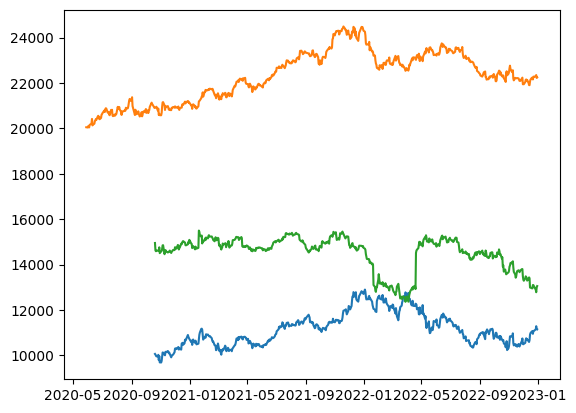

In [202]:
# Create strategy instances
strategy1 = MA_Strategy(symbol="AAPL", 
                        start="2020-01-01", 
                        end="2022-12-31", 
                        interval="1d",
                        capital=10000, 
                        transcation_cost=0.0, 
                        strategy_name="AAPL MAStrategy 50/200",
                        verbose=False)
strategy1.run_strategy(50, 200)
strategy1.performance()

strategy2 = MA_Strategy(symbol="MSFT", 
                        start="2020-01-01", 
                        end="2022-12-31", 
                        interval="1d",
                        capital=20000, 
                        transcation_cost=0.0, 
                        strategy_name="MSFT MAStrategy 20/100",
                        verbose=False)
strategy2.run_strategy(20, 100)
strategy2.performance()


strategy3 = MA_Strategy(symbol="NFLX", 
                        start="2020-01-01", 
                        end="2022-12-31", 
                        interval="1d",
                        capital=15000, 
                        transcation_cost=0.0, 
                        strategy_name="NFLX MAStrategy 50/200",
                        verbose=False)
strategy3.run_strategy(100, 200)
strategy3.performance()

# Create a portfolio with these strategies
portfolio = Portfolio(strategies=[strategy1, strategy2, strategy3])

In [203]:
metrics = portfolio.calculate_portfolio_metrics()
for metric, value in metrics.items():
    print(f"{metric}: {value:.2%}")

# Plot portfolio performance




Total Return: 3.22%
Annualized Return: 1.06%
Annualized Volatility: 7.03%
Sharpe Ratio: 15.11%


In [204]:
portfolio.portfolio_performance

,date,capital_AAPL MAStrategy 50/200,capital_MSFT MAStrategy 20/100,capital_NFLX MAStrategy 50/200,total_capital,portfolio_returns,cumulative_returns
0,2020-01-03,10000.000000,20000.000000,15000.000000,45000.000000,NaN,NaN
1,2020-01-06,10000.000000,20000.000000,15000.000000,45000.000000,0.000000,0.000000
2,2020-01-07,10000.000000,20000.000000,15000.000000,45000.000000,0.000000,0.000000
3,2020-01-08,10000.000000,20000.000000,15000.000000,45000.000000,0.000000,0.000000
4,2020-01-09,10000.000000,20000.000000,15000.000000,45000.000000,0.000000,0.000000
...,...,...,...,...,...,...,...
750,2022-12-23,11079.481812,22266.614258,13055.690491,46401.786560,-0.000846,0.031151
751,2022-12-27,11144.748291,22301.512329,12893.840820,46340.101440,-0.001329,0.029780
752,2022-12-28,11287.050354,22349.423401,12784.490692,46420.964447,0.001745,0.031577
753,2022-12-29,11159.728149,22221.660950,12998.090546,46379.479645,-0.000894,0.030655


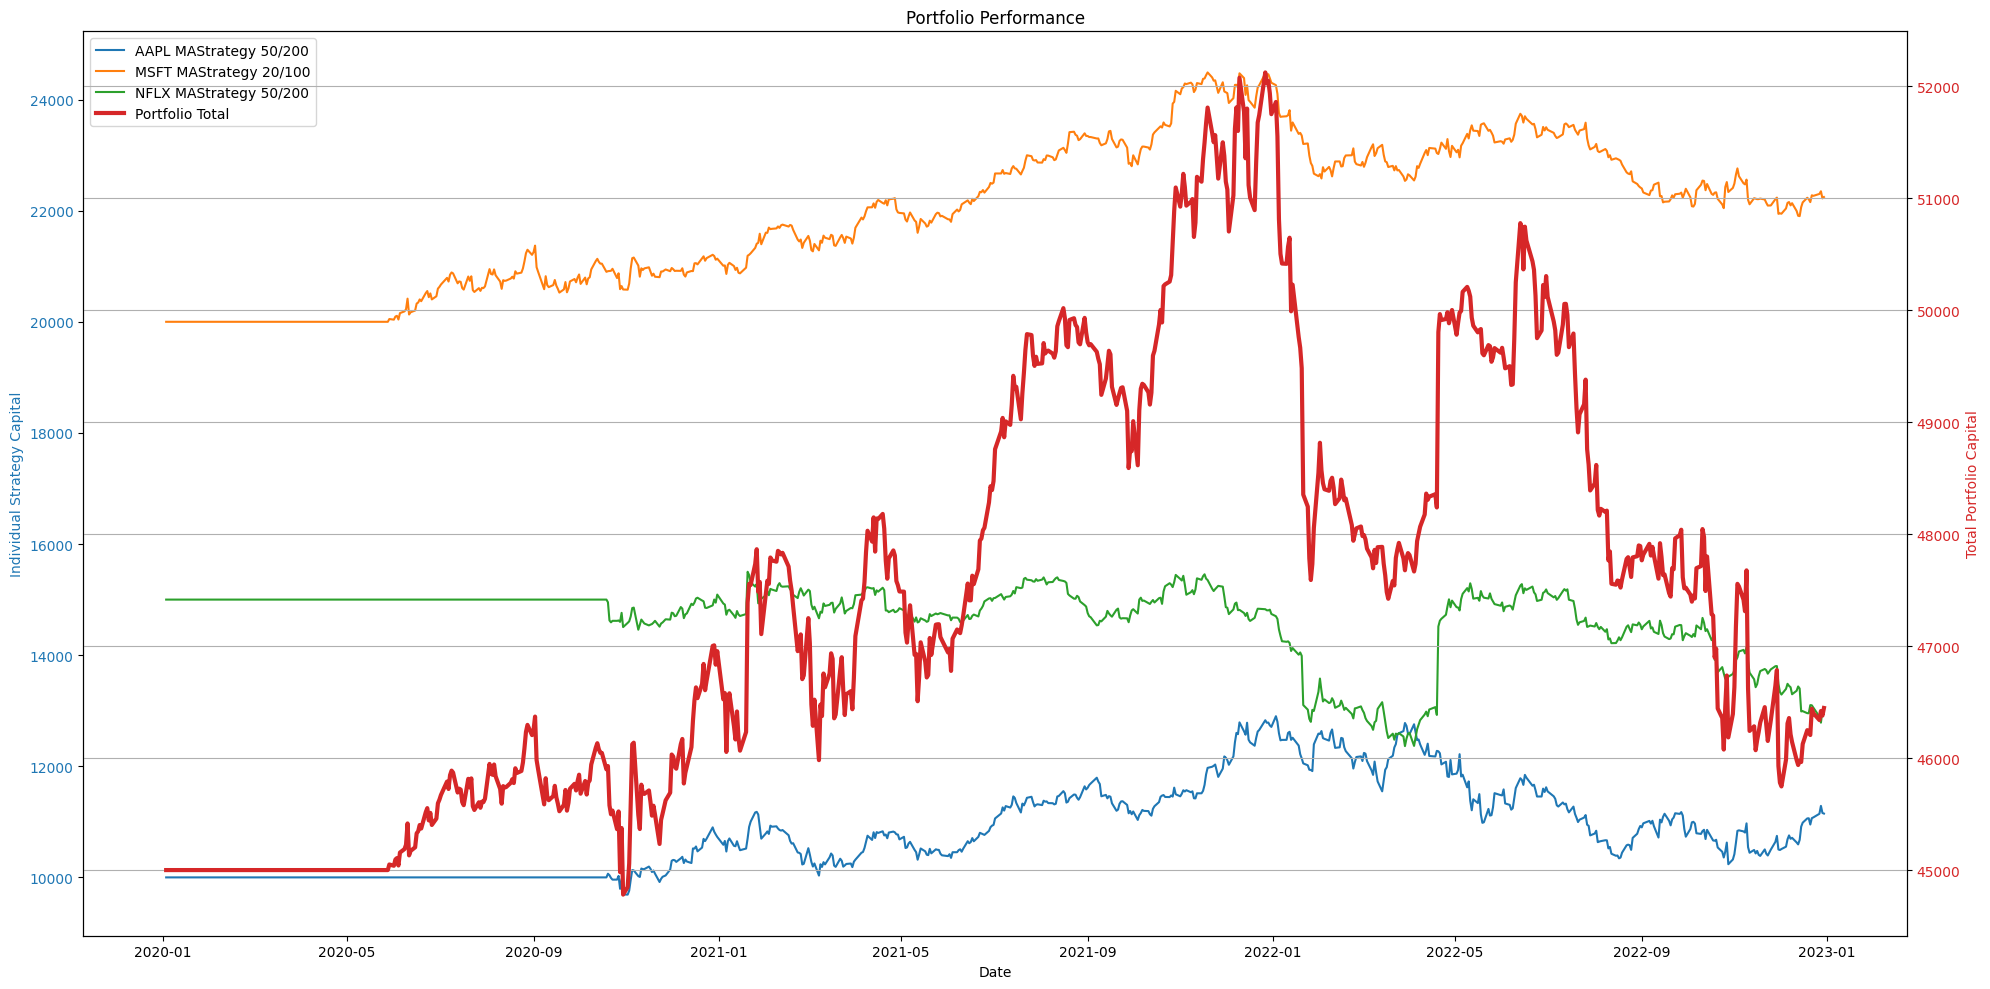

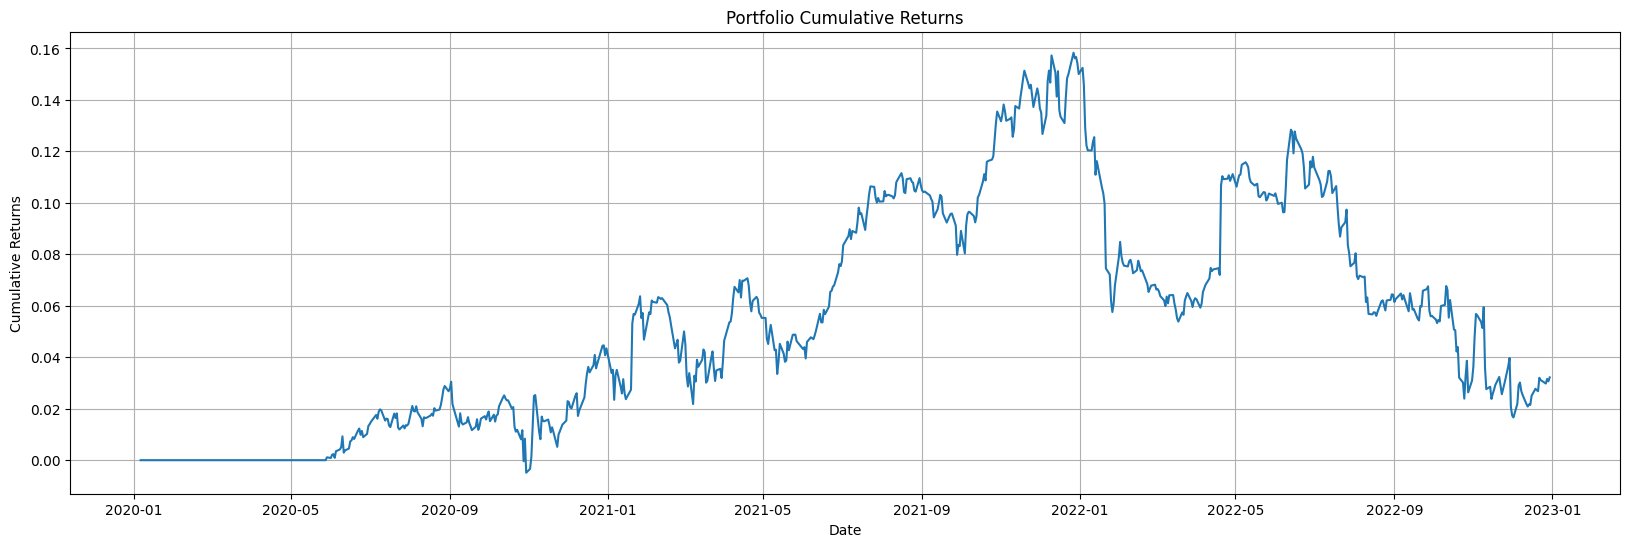

In [205]:
portfolio.plot_portfolio_performance()